In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

In [4]:
from lrann.datasets import DataLoader, random_train_test_split
from lrann.estimators import ImplicitEst, ExplicitEst
from lrann.models import BilinearNet
from lrann.utils import is_cuda_available
from lrann.evaluations import mrr_score, precision_recall_score

## Config

In [5]:
config = yaml.load(open('experiment_config.yml', 'r'))

/anaconda3/envs/lrann/lib/python3.6/site-packages/ipykernel_launcher.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """Entry point for launching an IPython kernel.


In [6]:
config

{'train_test_split_seed': 42,
 'torch_init_seed': 42,
 'estimator_init_seed': 42,
 'test_percentage': 0.2,
 'embedding_dim': 32,
 'mf_grid_search': {'torch_init_seed': [42, 147, 17, 28, 83],
  'l2': [0.0, 0.003, 0.01, 0.03],
  'learning_rate': [0.003, 0.01, 0.03],
  'n_epochs': 20,
  'eval_prec_k': [1, 5, 10]}}

## Data

In [7]:
data = DataLoader().load_movielens('100k')
data.binarize_(use_user_mean=True)

In [8]:
pd.Series(data.ratings).value_counts(normalize=False)

 1.0    54732
-1.0    46104
dtype: int64

In [9]:
train_data, test_data = random_train_test_split(data, test_percentage=config['test_percentage'],
                                                random_state=np.random.RandomState(seed=config['train_test_split_seed']))

In [10]:
train_data

<Interactions dataset (610 users x 9724 items x 80668 interactions)>

In [11]:
test_data

<Interactions dataset (610 users x 9724 items x 20168 interactions)>

## Model

In [ ]:
mf_model = BilinearNet(data.n_users, data.n_items,
                       embedding_dim=config['embedding_dim'],
                       torch_seed=config['torch_init_seed'])

In [ ]:
mf_est = ImplicitEst(model=mf_model, 
                     n_iter=1, 
                     use_cuda=is_cuda_available(),
                     random_state=np.random.RandomState(seed=config['estimator_init_seed']))

In [ ]:
mf_est.fit(train_data, verbose=True)

## Hyperparameter Optimization

Optimizing the MF hyperparameters to obtain a competitive baseline to beat by NN

5 random seeds x 4 regularizations x 3 learning rates x 20 epochs = 1200 steps and evaluations

In [12]:
grid_hyperparams = config['mf_grid_search']

In [13]:
grid_hyperparams

{'torch_init_seed': [42, 147, 17, 28, 83],
 'l2': [0.0, 0.003, 0.01, 0.03],
 'learning_rate': [0.003, 0.01, 0.03],
 'n_epochs': 20,
 'eval_prec_k': [1, 5, 10]}

In [ ]:
# Computation spread across multiple notebooks separating by `torch_init_seed`
results = []
counter = 0

for torch_init_seed in grid_hyperparams['torch_init_seed']:
    for learning_rate in grid_hyperparams['learning_rate']:
        for l2 in grid_hyperparams['l2']:
            
            mf_model = BilinearNet(data.n_users, data.n_items,
                                   embedding_dim=config['embedding_dim'],
                                   torch_seed=torch_init_seed)
            
            mf_est = ImplicitEst(model=mf_model, 
                                 n_iter=1, 
                                 use_cuda=is_cuda_available(),
                                 random_state=np.random.RandomState(seed=config['estimator_init_seed']),
                                 l2=l2,
                                 learning_rate=learning_rate)
            
            for epoch in range(grid_hyperparams['n_epochs']):
                
                start = time.time()
                
                mf_est.fit(train_data, verbose=False)
                
                # Evaluation
                mrr = mrr_score(mf_est, test_data).mean()
                prec_at_1 = precision_recall_score(mf_est, test_data, k=1)[0].mean()
                prec_at_5 = precision_recall_score(mf_est, test_data, k=5)[0].mean()
                prec_at_10 = precision_recall_score(mf_est, test_data, k=10)[0].mean()
                
                res = (torch_init_seed,
                       learning_rate,
                       l2,
                       epoch,
                       mrr,
                       prec_at_1,
                       prec_at_5,
                       prec_at_10)
                
                results.append(res)
                
                duration = int(time.time() - start)
                counter += 1
                
                print("Experiment {:04d}/240 took {} seconds".format(counter, duration))

In [17]:
results_df = pd.DataFrame(results, columns=['torch_init_seed',
                                            'learning_rate',
                                            'l2',
                                            'epoch',
                                            'mrr',
                                            'prec_at_1',
                                            'prec_at_5',
                                            'prec_at_10'])

In [51]:
results_df.to_csv('bilinear_net_mf_hyperparam_opt_res.csv', index=False)

In [53]:
results_df = pd.read_csv('bilinear_net_mf_hyperparam_opt_res.csv')

## Select the best configuration

In [54]:
results_df.sort_values('prec_at_10', ascending=False).head(10)

,torch_init_seed,learning_rate,l2,epoch,mrr,prec_at_1,prec_at_5,prec_at_10
971,83,0.003,0.0,11,0.028168,0.098361,0.099016,0.090656
972,83,0.003,0.0,12,0.028505,0.111475,0.101311,0.090328
973,83,0.003,0.0,13,0.028098,0.109836,0.101967,0.090328
19,42,0.003,0.0,19,0.029802,0.100000,0.102623,0.090000
18,42,0.003,0.0,18,0.027885,0.091803,0.087213,0.089508
251,147,0.003,0.0,11,0.030227,0.103279,0.099672,0.089180
13,42,0.003,0.0,13,0.027986,0.100000,0.095410,0.089016
11,42,0.003,0.0,11,0.028916,0.098361,0.096721,0.089016
970,83,0.003,0.0,10,0.028698,0.106557,0.095410,0.089016
8,42,0.003,0.0,8,0.027637,0.093443,0.096721,0.088689


In [55]:
results_df.sort_values('mrr', ascending=False).head(10)

,torch_init_seed,learning_rate,l2,epoch,mrr,prec_at_1,prec_at_5,prec_at_10
489,17,0.003,0.0,9,0.031317,0.116393,0.096721,0.083279
969,83,0.003,0.0,9,0.030325,0.108197,0.098689,0.087377
251,147,0.003,0.0,11,0.030227,0.103279,0.099672,0.089180
247,147,0.003,0.0,7,0.030030,0.121311,0.094098,0.082951
488,17,0.003,0.0,8,0.030005,0.111475,0.096066,0.084918
9,42,0.003,0.0,9,0.029977,0.106557,0.094098,0.087705
249,147,0.003,0.0,9,0.029884,0.106557,0.092459,0.085246
19,42,0.003,0.0,19,0.029802,0.100000,0.102623,0.090000
250,147,0.003,0.0,10,0.029474,0.095082,0.094754,0.085082
729,28,0.003,0.0,9,0.029015,0.103279,0.094754,0.082295


In [56]:
results_df[['mrr', 'prec_at_1', 'prec_at_5', 'prec_at_10']].corr()

,mrr,prec_at_1,prec_at_5,prec_at_10
mrr,1.000000,0.633337,0.889195,0.926733
prec_at_1,0.633337,1.000000,0.566549,0.537118
prec_at_5,0.889195,0.566549,1.000000,0.935955
prec_at_10,0.926733,0.537118,0.935955,1.000000


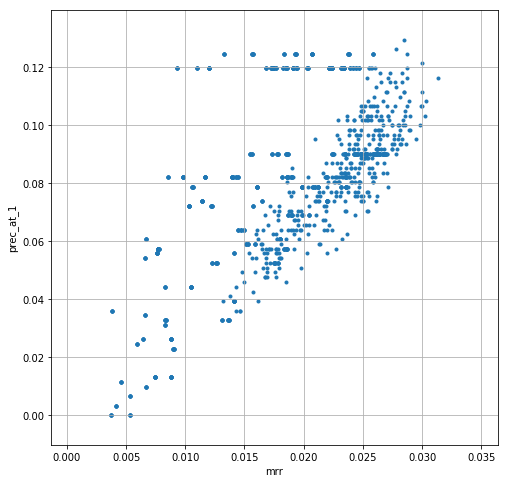

In [57]:
prec_type = 'prec_at_1'
plt.figure(figsize=(8,8))
plt.scatter(results_df['mrr'], results_df[prec_type], marker='.')
plt.xlabel('mrr')
plt.ylabel(prec_type)
plt.grid(True)

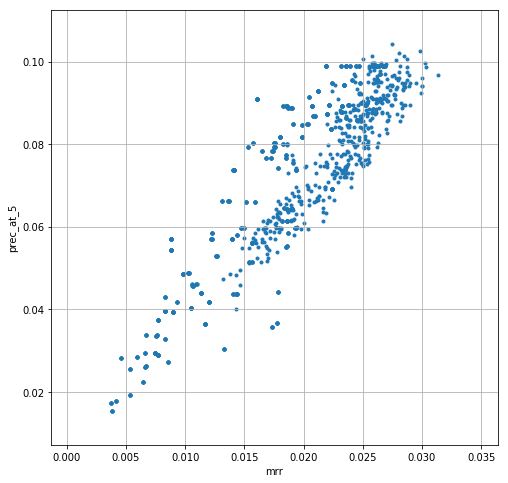

In [58]:
prec_type = 'prec_at_5'
plt.figure(figsize=(8,8))
plt.scatter(results_df['mrr'], results_df[prec_type], marker='.')
plt.xlabel('mrr')
plt.ylabel(prec_type)
plt.grid(True)

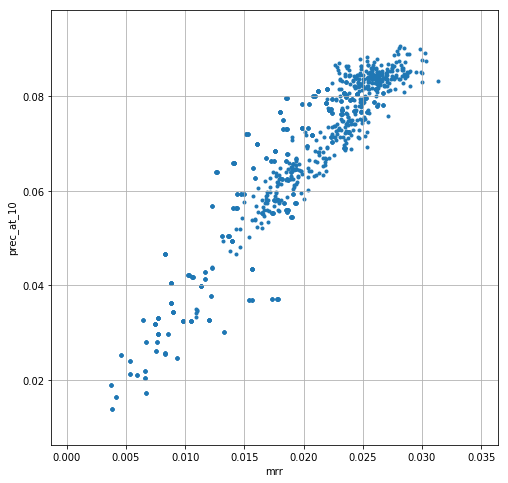

In [59]:
prec_type = 'prec_at_10'
plt.figure(figsize=(8,8))
plt.scatter(results_df['mrr'], results_df[prec_type], marker='.')
plt.xlabel('mrr')
plt.ylabel(prec_type)
plt.grid(True)

**Best BilinearNet Matrix Factorization Configuration (optimizing for MRR)**

In [60]:
results_df.sort_values('mrr', ascending=False).iloc[0]

torch_init_seed    17.000000
learning_rate       0.003000
l2                  0.000000
epoch               9.000000
mrr                 0.031317
prec_at_1           0.116393
prec_at_5           0.096721
prec_at_10          0.083279
Name: 489, dtype: float64